<h1><center>Daily Covid-19 Deaths</center></h1>
From <a href = "https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/">NHS page</a> on Covid-19 deaths.

In [1]:
import requests, bs4, os
import numpy as np
import pandas as pd


## Find spreadsheet link

In [2]:
root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")

for elem in linkElems:
    url = elem.get('href')
    if "COVID-19-total-announced-deaths" in url and not "weekly" in url:
        link = url

print("Link:", link)

Link: https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2021/02/COVID-19-total-announced-deaths-14-February-2021.xlsx


## Load Spreadsheet

In [3]:
resp = requests.get(link)

# Store the data in a temporary file
tempfile = open('tempfile.xls', 'wb')
tempfile.write(resp.content)
tempfile.close()

sheet = pd.read_excel('tempfile.xls', sheet_name='Tab4 Deaths by trust', skiprows=15)

# get names
names = np.delete(sheet["Name"].values,1) # (deleting empty space)

#get dates
dates = sheet.columns.values[6:-4]

deaths = np.delete(sheet.values[:,6:-4], 1, 0) # (deleting empty row)
os.remove("tempfile.xls")
print("Spreadsheet loaded.")

Spreadsheet loaded.


## Check plot

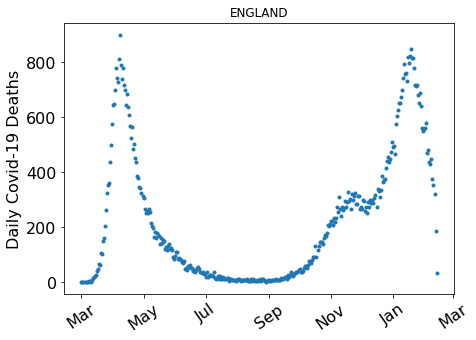

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=16)

index = 0

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
ax.set_title(names[index], size = 12)

ax.plot(dates, deaths[index,:], ".")
ax.set_ylabel("Daily Covid-19 Deaths")
ax.xaxis.set_tick_params(rotation=35)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_ylabel("Daily Covid-19 Deaths")
plt.show()

## Save data

In [5]:
np.save("covid_deaths.npy", [names, dates, deaths])

In [6]:
print("Total covid19 related deaths in English hospitals: {}".format(int(np.sum(deaths[0]))))

Total covid19 related deaths in English hospitals: 78889


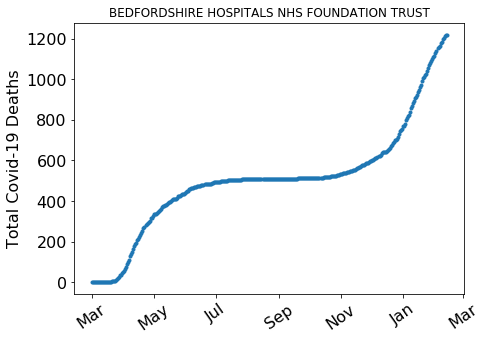

In [7]:
index = 3

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
ax.set_title(names[index], size = 12)

ax.plot(dates, np.cumsum(deaths[index,:]), ".")
ax.set_ylabel("Total Covid-19 Deaths")
ax.xaxis.set_tick_params(rotation=35)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))